In [67]:
colab = false #If running notebooks in Google Colab, set to true. If running Julia locally, change to false
if colab == true
  import Pkg

  Pkg.add("Distributions")
  Pkg.add("PyPlot")
  Pkg.add("PyCall")
  Pkg.add("DelimitedFiles")
  Pkg.add("LinearAlgebra")
  Pkg.add("Random")
  Pkg.add("SparseArrays")
  Pkg.add("JLD")
  Pkg.add("Statistics")
  Pkg.add("Git")

  # Load packages to be used. These packages must be installed first.

  using Git

  if isdir("TutorialCNS2025")
    # Remove the existing directory
    rm("TutorialCNS2025", recursive=true, force=true)
  end

  run(`git clone "https://github.com/chrismkkim/TutorialCNS2025.git"`)
  push!(LOAD_PATH, "/content/TutorialCNS2025")
  rep_path = "/content/TutorialCNS2025/"

else

  rep_path = "";

end

""

In [68]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using JLD
using Statistics

include(rep_path*"src_part3/param.jl");
include(rep_path*"src_part3/fun.jl");

# 1. Initial network: strongly and randomly connected excitatory-inhibitory neurons operating in the balanced regime

### Generate recurrent connections of the balanced network.

* Synaptic weights follow the scaling rule: $w_{ij} \sim \frac{1}{\sqrt{K}}$ where $K$ is the average number of connections each neuron receives.

* Each neuron receives constant external input that follows the scaling rule: $m \sim \sqrt{K}.$

* These initial connections of the balanced network will remain static throughout network training.

In [69]:
# Generate the (static) recurrent connections of a balanced network.
include(rep_path*"src_part3/genWeights.jl");
w0Index, w0Weights, nc0 = genWeights(p);

### Simulate the activity of balanced network. 

In [70]:
# Simulate the neural activity of the balanced network
include(rep_path*"src_part3/lifnet_sim.jl")
times, ns0, _, synExc, synInh = lifnet_sim(p, w0Index, w0Weights, nc0);


mean excitatory firing rate: 6.589333333333334 Hz
mean inhibitory firing rate: 11.963599999999998 Hz


Show strong recurrent excitatory and inhibitory synaptic inputs to neurons balancing each other.

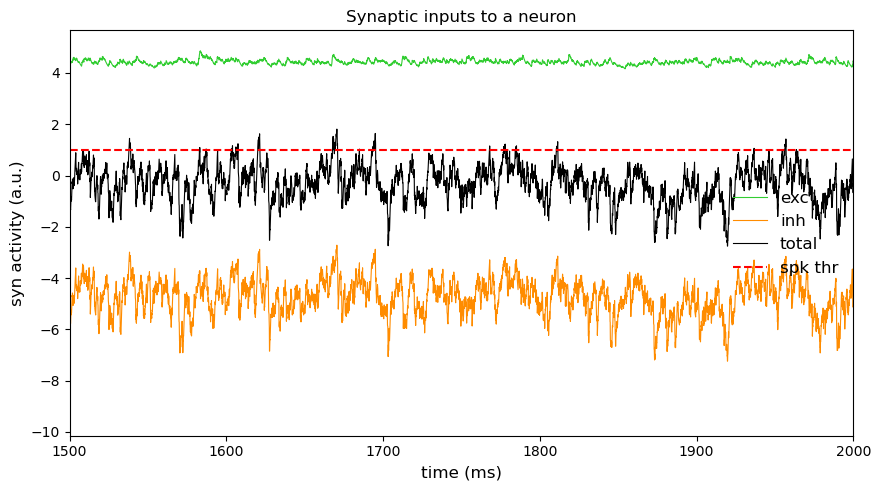

In [71]:
# Plot the synaptic inputs to a neuron
timev = collect(p.dt:p.dt:p.train_time)
figure(figsize=(10,5))
ci = 1
synNet = synExc[ci,:] .+ synInh[ci,:]
plot(timev, synExc[ci,:], lw=0.8, c="limegreen", label="exc")
plot(timev, synInh[ci,:], lw=0.8, c="darkorange", label="inh")
plot(timev, synNet, lw=0.8, c="k", label="total")
axhline(1, color="r", linestyle="--", lw=1.5, label="spk thr")
xlim([1500,2000])
title("Synaptic inputs to a neuron", fontsize=12)
xlabel("time (ms)", fontsize=12)
ylabel("syn activity (a.u.)", fontsize=12)
legend(bbox_to_anchor=[1.0, 0.5], frameon=false, fontsize=12)
tight_layout()
PyPlot.display_figs()

Show the spike times of neurons

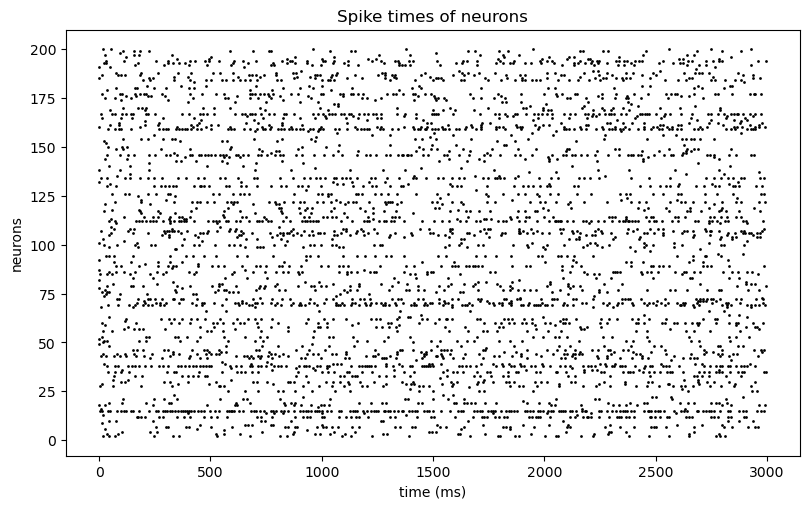

In [72]:
# Show spike times of a population of neurons
figure(figsize=(8,5))
title("Spike times of neurons")
for i = 1:200
    plot(times[i][1:ns0[i]], i*ones(ns0[i]), marker=".", ms=4, mec="None", c="k", linestyle="")
end
tight_layout()
xlabel("time (ms)")
ylabel("neurons")
PyPlot.display_figs()

# 2. Set up to train a subset of neurons to generate target activity patterns

### (a) Target activity patterns: ALM neurons firing rates

In [73]:
# select cells to be trained
rtarg_lickright = load(rep_path*"src_part3/data_alm/movingrate_Pyr1Hz_lickright.jld", "Pyr");
rtarg_lickleft = load(rep_path*"src_part3/data_alm/movingrate_Pyr1Hz_lickleft.jld", "Pyr");

# load targets
xtarg = Vector{Array{Float64,2}}()
utarg_R = transpose(load(rep_path*"src_part3/data_alm/utarg1Hz_lickright.jld", "utarg"));
utarg_L = transpose(load(rep_path*"src_part3/data_alm/utarg1Hz_lickleft.jld", "utarg"));
push!(xtarg, utarg_R);
push!(xtarg, utarg_L);


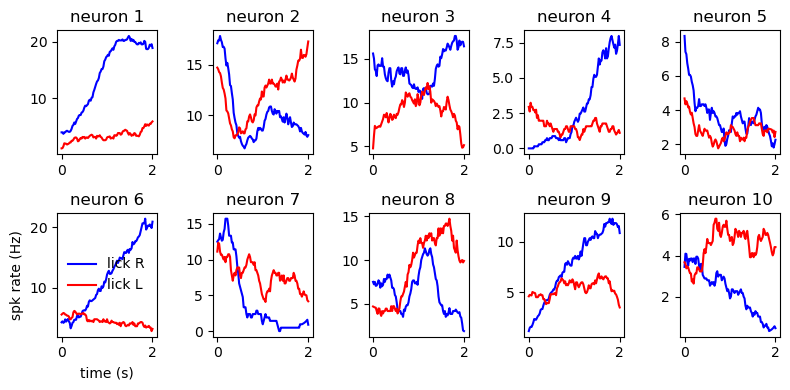

In [74]:
# Plot the activity patterns of ALM Pyramidal neurons
tvec = 0.02 * collect(0:100)
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("neuron $(ci)")
    plot(tvec, rtarg_lickright[ci,:], c="b", label="lick R")
    plot(tvec, rtarg_lickleft[ci,:], c="r", label="lick L")
    if ci == 6
        xlabel("time (s)")
        ylabel("spk rate (Hz)")
        legend(frameon=false, fontsize=10)
    end
end
tight_layout()
PyPlot.display_figs()

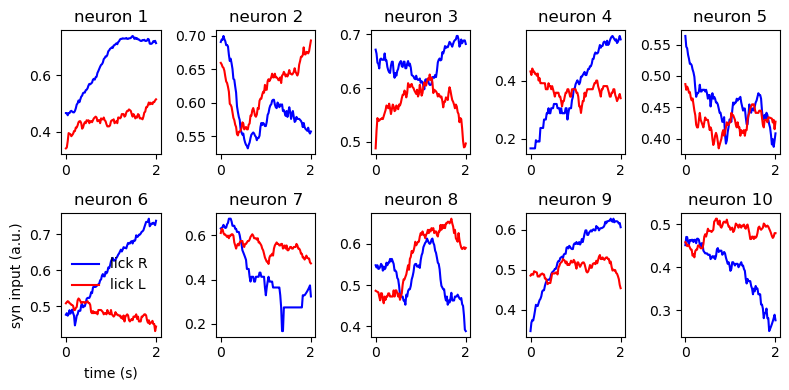

In [75]:
# Plot the activity patterns of ALM Pyramidal neurons
tvec = 0.02 * collect(0:100)
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("neuron $(ci)")
    plot(tvec, utarg_R[:,ci], c="b", label="lick R")
    plot(tvec, utarg_L[:,ci], c="r", label="lick L")
    if ci == 6
        xlabel("time (s)")
        ylabel("syn input (a.u.)")
        legend(frameon=false, fontsize=10)
    end
end
tight_layout()
PyPlot.display_figs()

### (b) Stimulus to trigger target activity patterns

In [76]:
# Generate stimulus to trigger response.
include(rep_path*"src_part3/genStim.jl")

stim = Vector{Array{Float64,1}}()
for lick = 1:2
    stim_val = genStim(p)
    push!(stim, stim_val);
end

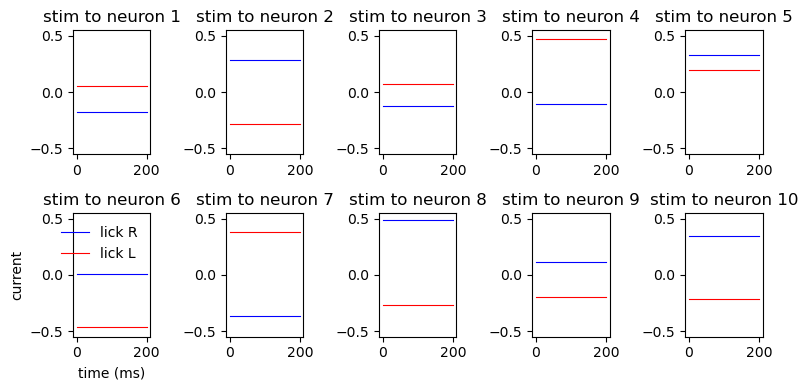

In [77]:
timev  = collect(0:200)
nsteps = size(timev)
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("stim to neuron $(ci)")
    plot(timev, stim[1][ci]*ones(nsteps), c="b", label="lick R", lw=0.8)
    plot(timev, stim[2][ci]*ones(nsteps), c="r", label="lick L", lw=0.8)
    ylim([-0.55,0.55])
    if ci == 6
        xlabel("time (ms)")
        ylabel("current")
        legend(frameon=false)
    end
end
tight_layout()
PyPlot.display_figs()

### (c) Select a subset of neurons to train

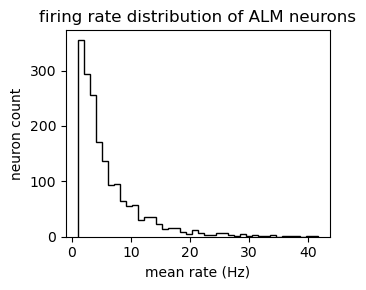

In [78]:
# firing rate distribution of ALM neurons
figure(figsize=(3.5,3))
title("firing rate distribution of ALM neurons")
mean_rate = mean(rtarg_lickright,dims=2)[:]
hist(mean_rate, bins=40, histtype="step", color="k")
xlabel("mean rate (Hz)")
ylabel("neuron count")
tight_layout()
PyPlot.display_figs()

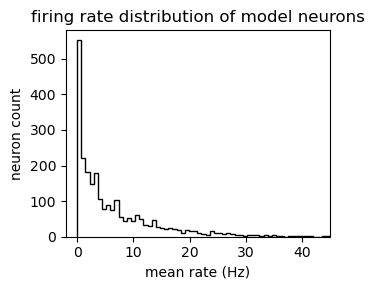

In [79]:
# firing rate distribution of model neurons
figure(figsize=(3.5,3))
title("firing rate distribution of model neurons")
hist(ns0[1:p.Ne] / (p.train_time/1000), bins=80, histtype="step", color="k")
xlabel("mean rate (Hz)")
ylabel("neuron count")
xlim([-2,45])
tight_layout()
PyPlot.display_figs()

Match the mean firing rates of ALM neurons and model neurons

In [80]:
include(rep_path*"src_part3/genCellsTrained.jl")
# sample a subset of neurons to be trained
Npyr = size(rtarg_lickleft,1) # Npyr = 1824
Ntrained = Npyr 
rtarg_mean = (rtarg_lickright + rtarg_lickleft)/2;
almOrd, matchedCells = genCellsTrained(p, rtarg_mean, ns0);


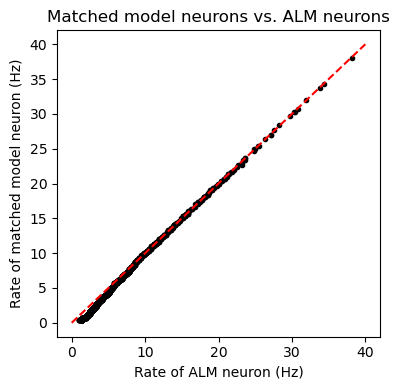

In [81]:
alm_mean_rate = mean(rtarg_mean,dims=2)[almOrd]
model_mean_rate = ns0[matchedCells] / (p.train_time/ 1000)
idline = collect(0:40)
figure(figsize=(4,4))
title("Matched model neurons vs. ALM neurons")
plot(alm_mean_rate, model_mean_rate, c="k", marker="o", ms=3, linestyle="")
plot(idline, idline, c="r", linestyle="--")
xlabel("Rate of ALM neuron (Hz)")
ylabel("Rate of matched model neuron (Hz)")
tight_layout()
PyPlot.display_figs()


### (d) Initialize sparse plastic synapses to train

For each trained neuron, a fixed number of presynaptic neurons ($\sim \sqrt{K}$) are randomly selected. The synapses from those presynaptic neurons are plastic and optimized by RLS.

In [82]:
# Generate plastic connections to be trained
include(rep_path*"src_part3/genPlasticWeights.jl")
include(rep_path*"src_part3/convertWgtIn2Out.jl")
wpWeightFfwd, wpWeightIn, wpWeightOut, 
wpIndexIn, wpIndexOut, wpIndexConvert, 
ncpIn, ncpOut = genPlasticWeights(p, w0Index, nc0, ns0, matchedCells);


### Initialize plastic feedforward conections to neurons (optional)

In [83]:
# generate feedforward drive
include(rep_path*"src_part3/genffwdRate.jl")

ffwdRate_mean = 5.0; # Hz
ffwdRate = Vector{Array{Float64,2}}();
for lick = 1:2
    ffwdRate_val = genffwdRate(p, ffwdRate_mean);
    push!(ffwdRate, ffwdRate_val);
end

## 3 Train a subset of neurons in the balanced network

Train a subset of neurons to follow target activity patterns

In [84]:
include(rep_path*"src_part3/lifnet_train.jl")
include(rep_path*"src_part3/lifnet_test.jl")
include(rep_path*"src_part3/runperformance.jl")
#define path to data network 
dirNetwork = rep_path*"src_part3/data_network/";

Running this cell trains the balanced network. It can take several hours (e.g. 2 hours on the latest MacBook). If you wish to train it, set train_balanced_net = true and run the cell.

In [85]:
train_balanced_net = false

if train_balanced_net
    p.nloop=200

    mode = "train"
    wpWeightIn, wpWeightOut, wpWeightFfwd = lifnet_train(dirNetwork,p,w0Index,w0Weights,nc0, stim, xtarg,
    wpWeightFfwd, wpIndexIn, wpIndexOut, wpIndexConvert, wpWeightIn, wpWeightOut, ncpIn, ncpOut,
    almOrd, matchedCells, ffwdRate, mode);
end



Save the trained network if you have trained it from the above cell.

In [86]:
include(rep_path*"src_part3/save_load_trained_ntwk.jl");
dir_trained_network = "src_part3/data_trained_network/";

In [87]:
#--- save a trained network ---#
if train_balanced_net
    save_trained_network(dir_trained_network)
end

Instead, you can load and simulate a previously trained network. All the parameters of the trained network are saved in the folder 'src_part3/data_trained_network'.

In [88]:

#--- load a previously trained network ---#
_p, _w0Index, _w0Weights, _wpWeightIn, _wpWeightOut, _wpWeightFfwd, 
_wpIndexIn, _wpIndexOut, _wpIndexConvert, 
_nc0, _ncpIn, _ncpOut, _xtarg, _stim, 
_almOrd, _matchedCells, _ffwdRate = load_trained_network(dir_trained_network);

#--- simulate a trained network ---#
_xtotal, _, _, _, _, _, 
_, _, _, _, 
_, _, _, _ = lifnet_test("",_p,_w0Index,_w0Weights,_nc0, _stim, _xtarg,
        _wpWeightFfwd, _wpIndexIn, _wpIndexOut, _wpIndexConvert, _wpWeightIn, _wpWeightOut, _ncpIn, _ncpOut,
        _almOrd, _matchedCells, _ffwdRate);


Show training performance

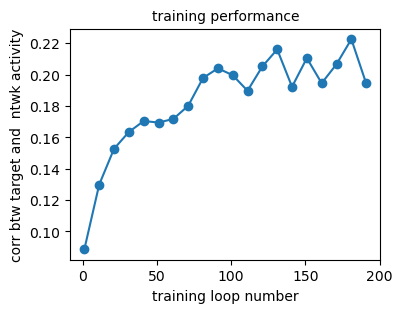

In [89]:
#Check correlation between xtarg and xtotal
loop_numbers = range(1, stop=p.nloop, step=10)
corr_vals=Float64[]

for l in 10:10:p.nloop
    filename = dirNetwork * "_performance_R_loop$(l).txt"
    corr = [parse(Float64, item) for item in readlines(filename)][1]
    push!(corr_vals, corr)
end
figure(figsize=(4,3))
plot(loop_numbers, corr_vals,"-o")
title("training performance", fontsize=10)
ylabel("corr btw target and  ntwk activity", fontsize=10)
xlabel("training loop number", fontsize=10)
PyPlot.display_figs()

## 4 Show the activity of trained neurons

To demonstrate if trained neurons follow their target activity patterns, we simulated and saved the synaptic activity of a trained network.

In [90]:
iloop=200
xtotal_pretrained = load(dirNetwork * "xtotal_$(iloop).jld")["xtotal"];
times_pretrained = load(dirNetwork * "times_$(iloop).jld")["times"];
ns_pretrained = load(dirNetwork * "ns_$(iloop).jld")["ns"];
almOrd_pretrained = load(dirNetwork * "almOrd.jld")["almOrd"];
matchedCells_pretrained = load(dirNetwork * "matchedCells.jld")["matchedCells"];


Show that trained neurons' activity follow the target activity patterns

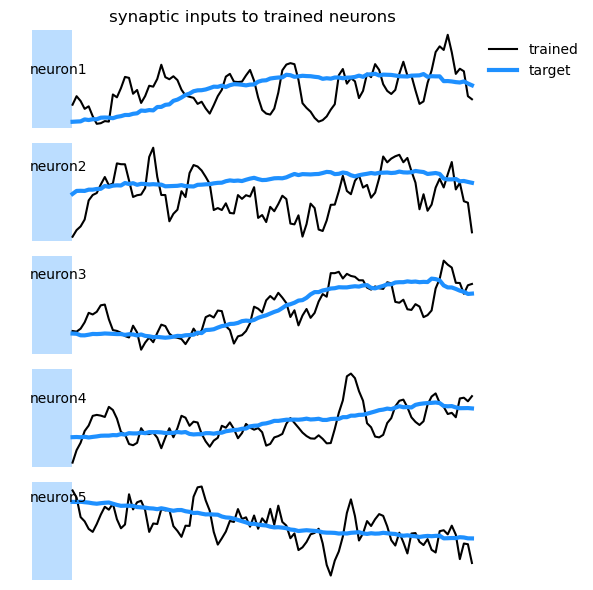

In [91]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt);
ttarg = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt); #.+ 2000.0

figure(figsize=(6,6))
for ci = 1:5
    subplot(5,1,ci)
    ci_rnd = shuffle(collect(1:Ntrained))[1]
    cell_model = matchedCells_pretrained[ci]
    cell_alm   = almOrd_pretrained[ci]
    axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
    # plot(tvec, xtotal[:,cell_model].+p.muemax, c="k", label = "trained")
    plot(tvec, xtotal_pretrained[:,cell_model].+p.muemax, c="k", label = "trained")
    plot(ttarg, xtarg[1][2:end,cell_alm], c="dodgerblue", lw=3, label="target")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-100,maximum(xtarg[1][2:end,cell_alm])), fontsize=10)        
    if ci ==1
        title("synaptic inputs to trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.0),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

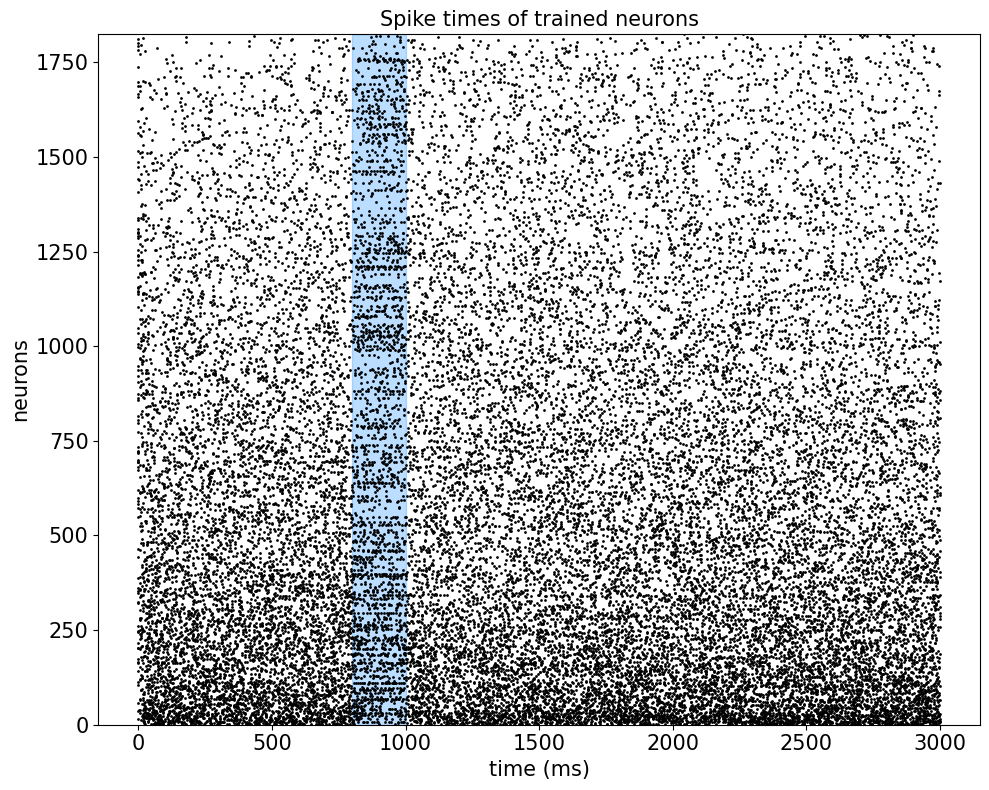

In [92]:
# Show spike times of a population of neurons
figure(figsize=(10,8))
title("Spike times of trained neurons", fontsize=15)
axvspan(800, 1000, color="dodgerblue", alpha=0.3)
for ci = 1:Ntrained
    cell_model = matchedCells_pretrained[ci]
    plot(times_pretrained[cell_model][1:ns_pretrained[cell_model]], ci*ones(ns_pretrained[cell_model]), marker=".", ms=4, mec="None", c="k", linestyle="")
end
plt.ylim([0,Ntrained])
xlabel("time (ms)", fontsize=15)
ylabel("neurons", fontsize=15)
xticks(fontsize=15)
yticks(fontsize=15)
tight_layout()
# savefig("figure/spiking_balanced_spkraster.png", dpi=300)
PyPlot.display_figs()

## 2.3 Show the activity of untrained neurons

We have characterized the activity of the cells trained to produce the activity measured experimentally. We would now like to characterize the activity of the untrained cells to see if they are influenced by the task-related activity.


In [93]:
#Extract the strongest-responding untrained excitatory cells
untrained_cells = []

for ci = 1:p.Ncells
    if !(ci in matchedCells_pretrained) && ci <= p.Ne
        ave_untrained_activity = mean(xtotal_pretrained[:,ci].+p.muemax, dims=1)
        push!(untrained_cells, [ci,ave_untrained_activity])
    elseif !(ci in matchedCells_pretrained) && ci > p.Ne
        ave_untrained_activity = mean(xtotal_pretrained[:,ci].+p.muimax, dims=1)
        push!(untrained_cells, [ci,ave_untrained_activity])
    end

end

untrained_cells_sorted = sort(untrained_cells, by = x -> x[2]; rev=true);


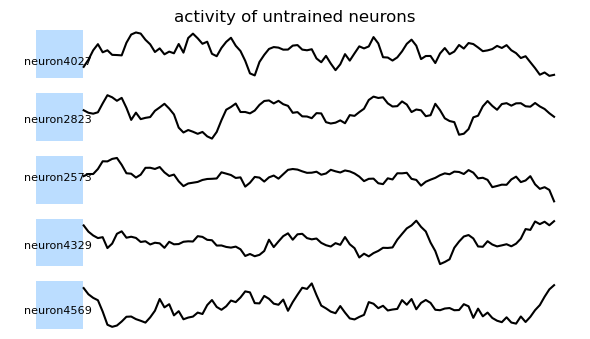

In [94]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)
ttarg = collect((p.stim_on+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)

figure(figsize=(6,6))

i=1
for ci in [x[1] for x in untrained_cells_sorted[1:9]]
    if i <= 5 
        subplot(9,1,i)
        axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
        plot(tvec, xtotal_pretrained[:,ci].+p.muemax, c="k", label = "trained")
        annotate("neuron$(ci)", ((p.stim_on/p.dt)-500,2.5), fontsize=8)
        
        if i ==1 
            title("activity of untrained neurons")
        end
        axis("off")
        #ylim(0,4)
        i+=1
    end
end
tight_layout()
PyPlot.display_figs()

The above demonstrates that there is strong activity in the untrained cells. Let's compare the distribution of mean responses for untrained excitatory and inhibitory cells.

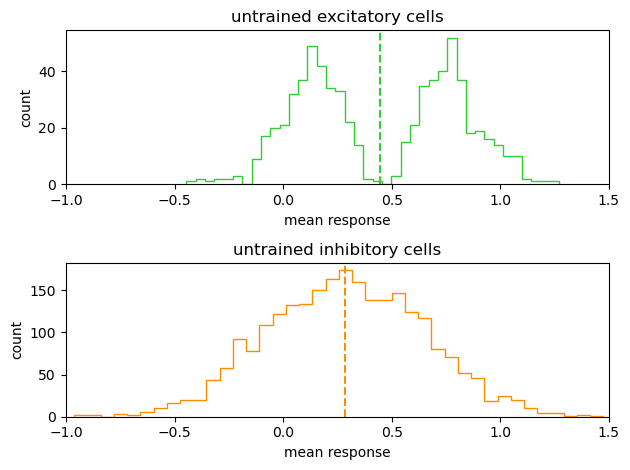

In [95]:
# Plot the distribution of  mean activity for untrained E and I cells.
untrained_E_resp = [x[2][1] for x in untrained_cells_sorted if x[1] <= p.Ne]
untrained_I_resp = [x[2][1] for x in untrained_cells_sorted if x[1] > p.Ne]

subplot(2, 1, 1)
hist(untrained_E_resp, bins=40, histtype="step", color="limegreen")
axvline(mean(untrained_E_resp), color="limegreen", linestyle="--") #indicates population average for E cells
title("untrained excitatory cells")
xlabel("mean response")
ylabel("count")
xlim(-1,1.5)

subplot(2, 1, 2)
hist(untrained_I_resp, bins=40, histtype="step", color="darkorange")
axvline(mean(untrained_I_resp), color="darkorange", linestyle="--") #indicates population average for I cells
title("untrained inhibitory cells")
xlabel("mean response")
ylabel("count")
xlim(-1,1.5)

tight_layout()
show()